# Feature importance check

In [1]:

from src.util import read_results, train_test_validate_split, ExplodeColumns, model_operators, eval_result
import numpy as np 
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
# plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

%load_ext autoreload
%autoreload 2

In [2]:
result_df = read_results(from_parquet=True)

In [3]:
list_features = [x for x in result_df.columns if result_df[x].apply(lambda x: isinstance(x, (list, np.ndarray))).any()]
result_df = ExplodeColumns(columns=list_features, max_len=5).transform(result_df)

Expanding columns: 100%|██████████| 7/7 [03:34<00:00, 30.62s/it]


In [4]:
categorical_columns = result_df.select_dtypes(include=['object']).columns.tolist()
print(f"Dropping {categorical_columns}")
for col in categorical_columns:
    result_df[col] = result_df[col].astype('category')

Dropping ['dataset', 'operator', 'join', 'compute_unit', 'source_file', 'dataset_type', 'compute_type', 'parallelism', 'gpu__architecture']


In [5]:
target_cols = ['speedup', 'times_mean', 'label', 'time_saved', 'materialized_times_mean']

def split_data(df, target_cols):
    X = df.drop(columns=target_cols)
    y = df[target_cols]
    return X, y

train, test, validate = train_test_validate_split(result_df)
X_train, y_train = split_data(train, target_cols)
X_test, y_test = split_data(test, target_cols)
X_validate, y_validate = split_data(validate, target_cols)


train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39648/171305 = 0.23 s
	Dataset types: ['synthetic', 'hamlet']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['v100', 'CPU 08c', 'p100', 'CPU 16c', '1080', 'CPU 32c', '2080', 'a40']
Categories (8, object): ['1080', '2080', 'CPU 08c', 'CPU 16c', 'CPU 32c', 'a40', 'p100', 'v100']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 16772/73637 = 0.23 s
	Dataset types: ['synthetic', 'hamlet']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['CPU 32c', '2080', 'CPU 16c', '1080', 'CPU 08c', 'v100', 'p100', 'a40']
Categories (8, object): ['1080', '2080', 'CPU 08c', 'CPU 16c', 'CPU 32c', 'a40', 'p100', 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic', 'hamlet', 'tpc_ai']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['p100',

In [6]:
train[['mem_mat_read', 'features_0']]

,mem_mat_read,features_0
133772,1.030042e+07,1.287552e+06
23759,1.889897e+07,7.488000e+08
197667,5.900508e+06,7.400000e+07
100270,7.257600e+06,9.072000e+05
139477,9.760000e+06,1.220000e+06
...,...,...
131085,1.072189e+11,1.072189e+11
296708,8.000008e+07,1.000001e+07
144646,8.000008e+07,1.000001e+07
162363,8.944272e+10,1.500000e+08


In [7]:
cols = result_df.head(1).T

In [8]:
from sklearn.metrics import mean_squared_error
import seaborn as sns


def plot_boundary(y_true, y_pred, lower=-1.0, upper=1.0, step=0.1, target_col=None, full_dataset=None, ax=None):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x = np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred=y_pred > boundary, full_dataset=full_dataset, target_col=target_col)
        results.append({"boundary": boundary, **result[2]})

    dd = pd.DataFrame(results)
    ax = sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label="time_saved", ax=ax)
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label="speedup", color="orange")
    ax.grid()
    ax.legend(loc="lower right")
    ax.set_title(f"Boundary vs. Time saved {target_col}")
    return ax


def train_and_eval(name, X_train, y_train, X_test, y_test, X_validate, y_validate, target_col, only_model=False, estimator_kwargs={}):
    model_operators_mask_test = X_test["operator"].isin(model_operators)
    X_test = X_test.loc[model_operators_mask_test]
    y_test = y_test.loc[model_operators_mask_test]

    model_operators_mask_validate = X_validate["operator"].isin(model_operators)
    X_validate = X_validate[model_operators_mask_validate]
    y_validate = y_validate.loc[model_operators_mask_validate]
    df_filtered = result_df[result_df["operator"].isin(model_operators)]
    if only_model:
        # Filter the datasets based on the condition
        model_operators_mask_train = X_train["operator"].isin(model_operators)
        X_train = X_train[model_operators_mask_train]
        y_train = y_train.loc[model_operators_mask_train]
    else:
        df_filtered = result_df

    clf = xgboost.XGBRegressor(enable_categorical=True, **estimator_kwargs)
    clf.fit(X_train, y_train[target_col])
    display(pd.DataFrame(zip(X_train.columns, clf.feature_importances_)).sort_values(1, ascending=False).head(10))
    X_validate = X_validate[X_validate.operator.isin(model_operators)]
    y_validate= y_validate.loc[X_validate.index]
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for X, y, dataset_name, ax in zip(
        [X_train, X_test, X_validate], [y_train, y_test, y_validate], ["train", "test", "validate"], axs
    ):
        plt.sca(ax)
        y_true = y[target_col]
        y_pred = clf.predict(X)
        print(name, dataset_name, mean_squared_error(y_true, y_pred))

        if isinstance(target_col, list):
            print("Assuming target cols are materialized_times_mean and times_mean")
            pred = pd.DataFrame(y_pred, index=y_true.index)
            pred.columns = y_true.columns
            y_pred = pred["materialized_times_mean"] - pred["times_mean"]
            y_true = y_true["materialized_times_mean"] - y_true["times_mean"]
            eval_target_col = 'time_saved'
        else:
            eval_target_col = target_col

        lower, upper = (0.8, 2.0) if target_col == "speedup" else (-1.0, 1.0)
        ax = plot_boundary(y_true, y_pred, lower,upper, target_col=eval_target_col, full_dataset=df_filtered.loc[y_true.index],ax=ax)
        xgb_results[(name, dataset_name)] = eval_result(
            y_true,
            y_pred,
            full_dataset=df_filtered.loc[y_true.index],
            model_name=f"{name}: {dataset_name}",
            target_col=eval_target_col,
            plot=True,
        )[0]
    return clf

[(['times_mean', 'materialized_times_mean'], True),
 (['times_mean', 'materialized_times_mean'], False),
 ('speedup', True),
 ('speedup', False),
 ('time_saved', False),
 ('time_saved', True)]

,0,1
0,operator,0.263442
11,mem_fac_read,0.151545
1,num_cores,0.105430
31,mem_read_colsum,0.072584
38,comp_fac,0.061896
48,sparsity_T,0.048266
9,mem_mat_read,0.041812
21,comp_scalar_dense,0.031637
3,cardinality_T,0.031112
24,comp_matrix_dense,0.030129


XGB.1 train 0.08620970551531126
Assuming target cols are materialized_times_mean and times_mean
XGB.1 test 0.25023127475248286
Assuming target cols are materialized_times_mean and times_mean
XGB.1 validate 18.636846589821634
Assuming target cols are materialized_times_mean and times_mean


,0,1
0,operator,0.207868
68,features_2,0.120397
66,features_0,0.115760
21,comp_scalar_dense,0.108010
11,mem_fac_read,0.084170
1,num_cores,0.079757
38,comp_fac,0.063552
48,sparsity_T,0.032148
3,cardinality_T,0.022718
14,comp_lmm_mat,0.018854


XGB.2 train 0.02113454906685756
Assuming target cols are materialized_times_mean and times_mean
XGB.2 test 0.2599577415126677
Assuming target cols are materialized_times_mean and times_mean
XGB.2 validate 19.04915394202124
Assuming target cols are materialized_times_mean and times_mean


,0,1
29,mem_read_rowsum,0.136501
37,comp_mat,0.114872
27,mem_read_matrix_dense,0.054495
44,nnz_T,0.051532
1,num_cores,0.050369
39,comp_ratio,0.043446
47,c_T,0.043144
0,operator,0.036385
11,mem_fac_read,0.034832
48,sparsity_T,0.028798


XGB.3 train 0.0058027432182210115
XGB.3 test 0.021585792734113648
XGB.3 validate 2.384392279346448


,0,1
73,r_S_2,0.413825
2,selectivity,0.219798
55,gpu_cache_size_l1,0.113386
77,c_S_1,0.065619
0,operator,0.042277
1,num_cores,0.037383
52,gpu__architecture,0.029146
10,mem_mat_write,0.015562
47,c_T,0.014240
92,morpheusfi_eis_1,0.009114


XGB.4 train 3.721971473504027
XGB.4 test 0.05178712288504648
XGB.4 validate 15.004620487558821


,0,1
0,operator,0.317963
1,num_cores,0.100737
72,r_S_1,0.073218
45,nnz_S_sum,0.069705
6,complexity_ratio,0.054370
39,comp_ratio,0.053440
68,features_2,0.046572
41,fr,0.038218
48,sparsity_T,0.032948
70,features_4,0.030573


XGB.5 train 0.04781230099613182
XGB.5 test 0.5272440403368079
XGB.5 validate 11.03744881447951


,0,1
0,operator,0.232674
1,num_cores,0.126886
41,fr,0.090209
6,complexity_ratio,0.087710
72,r_S_1,0.072724
45,nnz_S_sum,0.060449
48,sparsity_T,0.048044
11,mem_fac_read,0.044407
3,cardinality_T,0.038121
37,comp_mat,0.028729


/tmp/ipykernel_27131/3053750103.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(15, 4))


XGB.6 train 0.17409128425639367
XGB.6 test 0.49119464498817705
XGB.6 validate 10.789433502053113


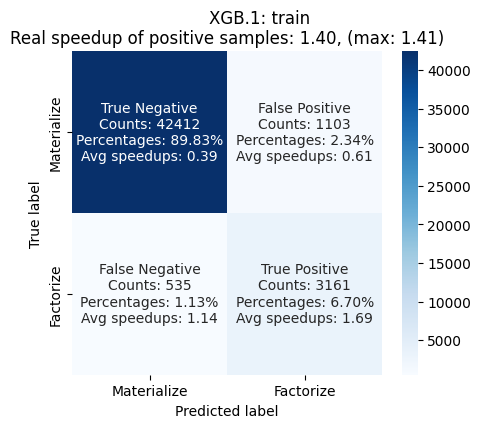

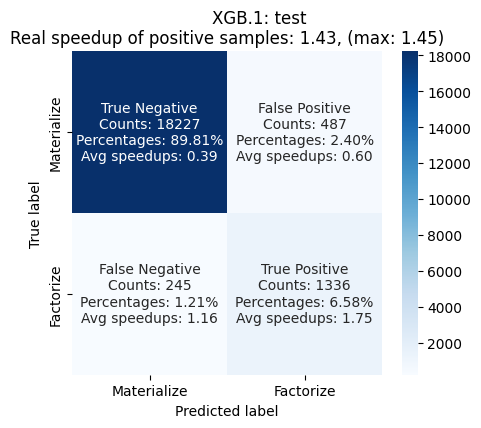

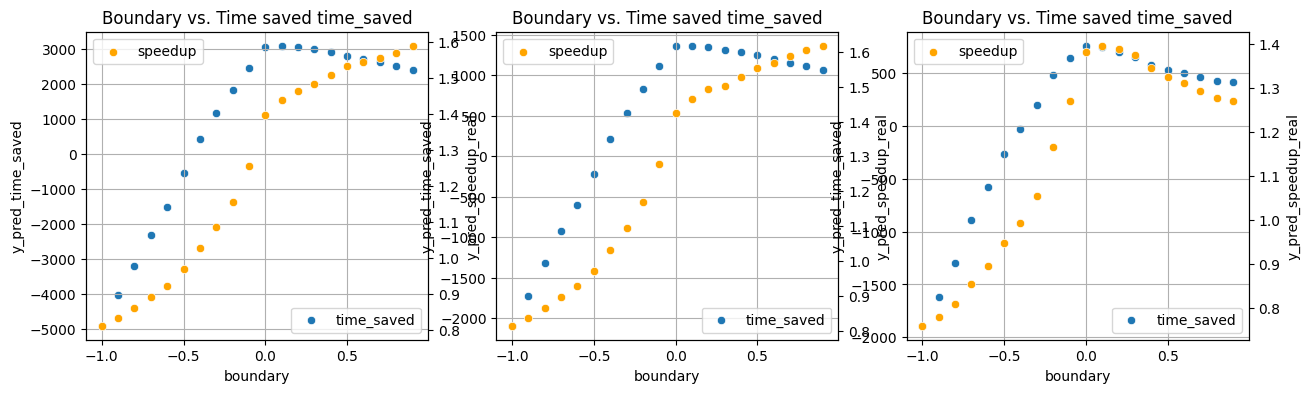

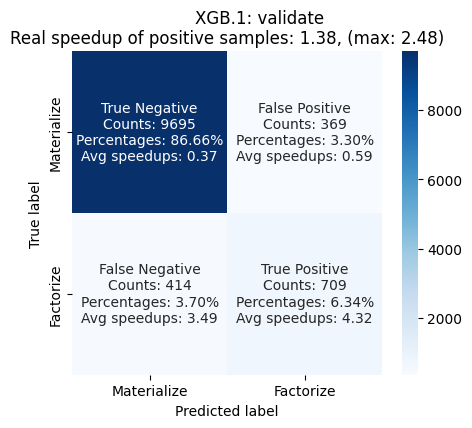

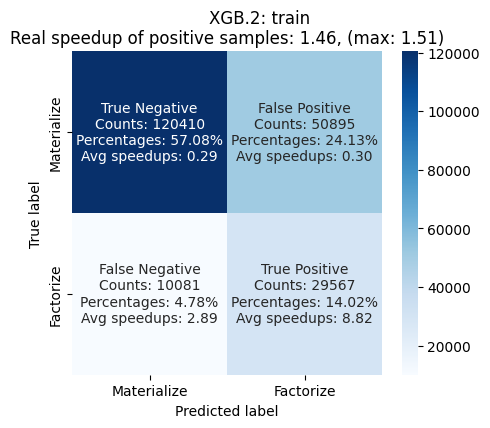

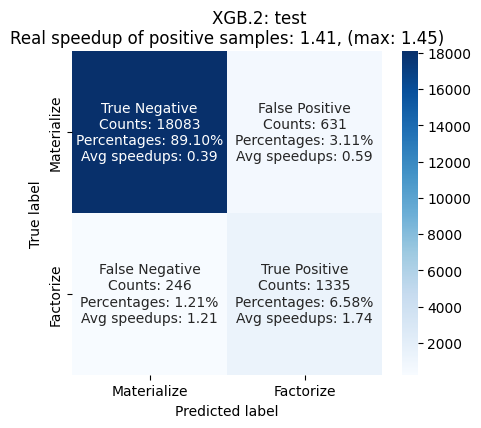

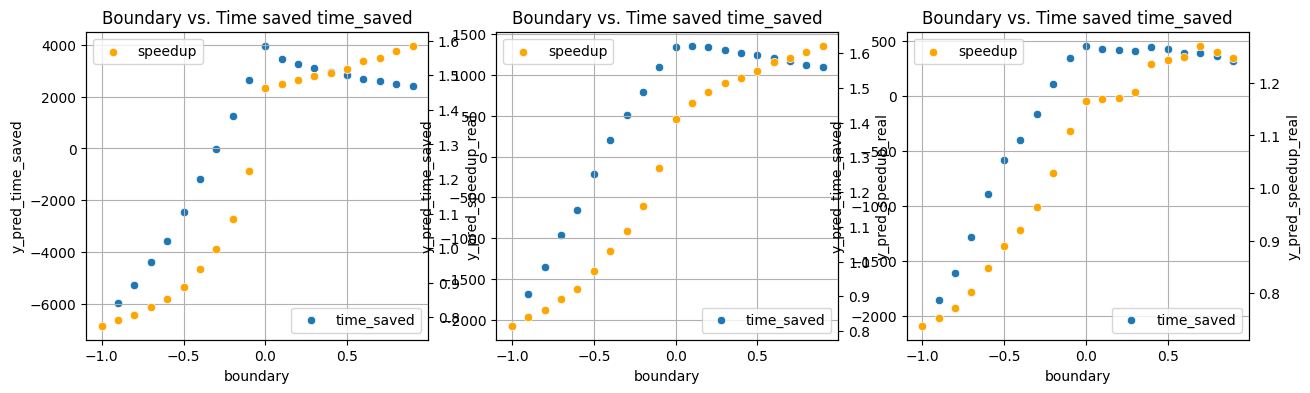

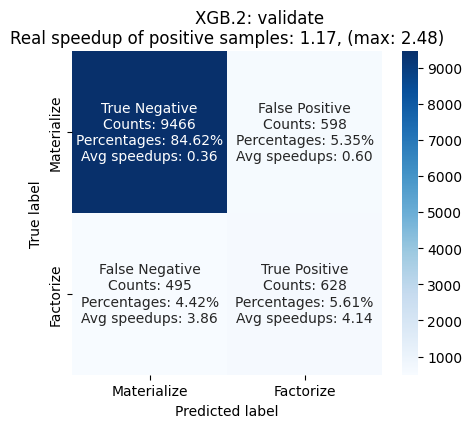

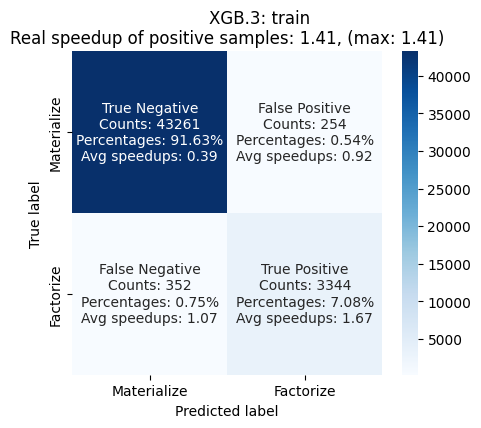

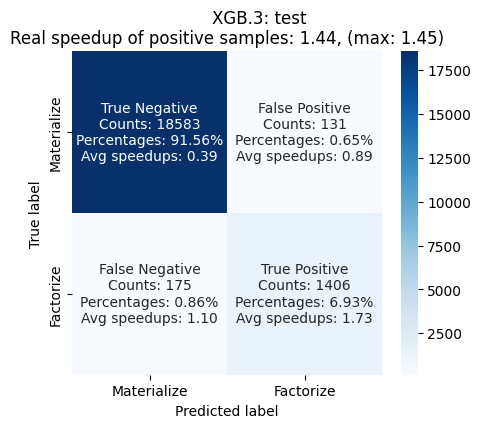

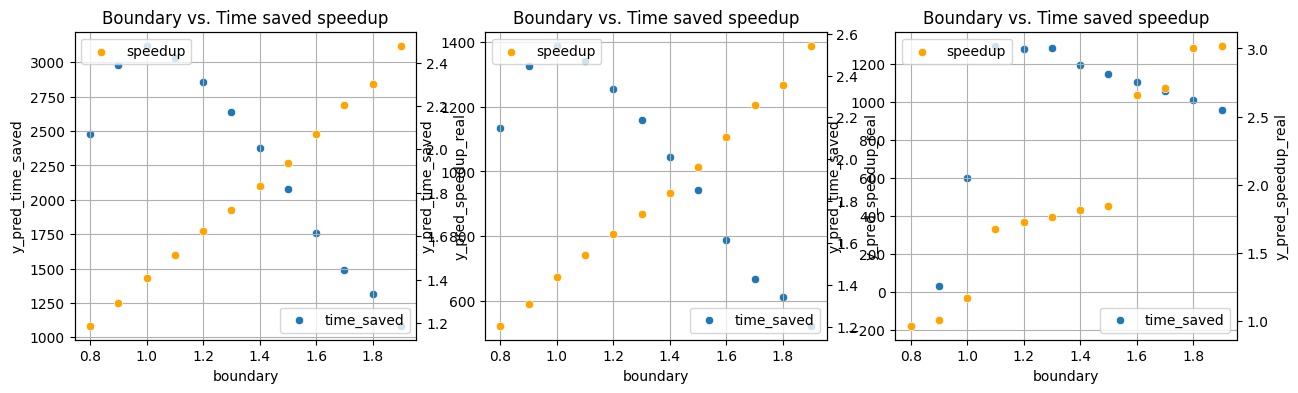

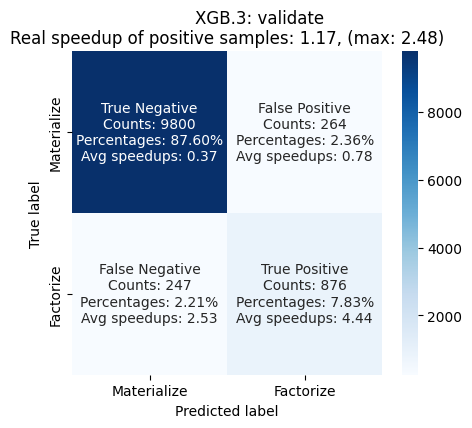

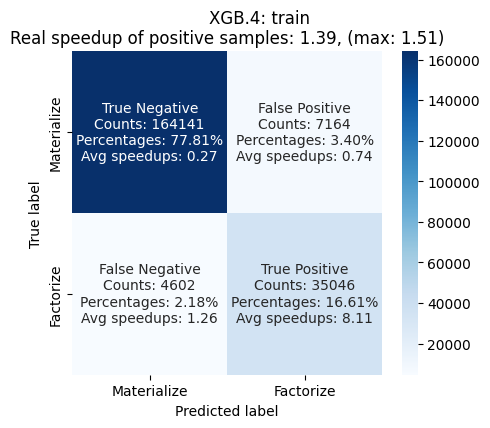

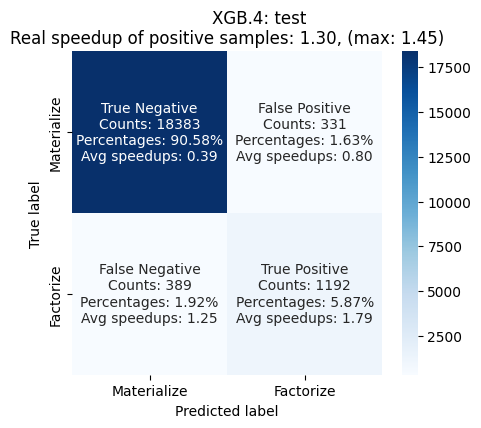

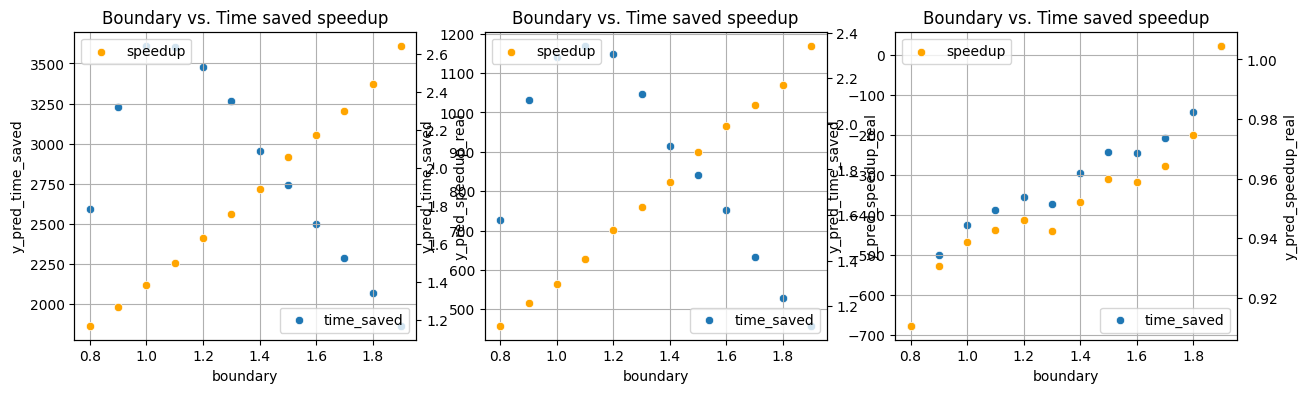

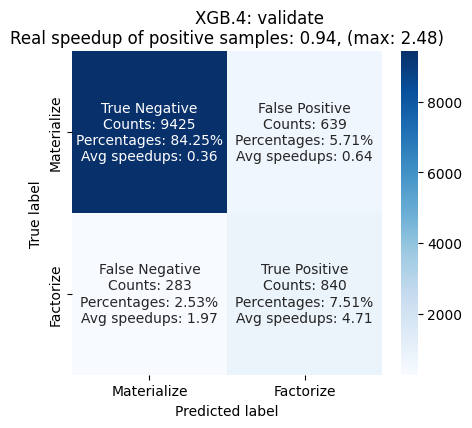

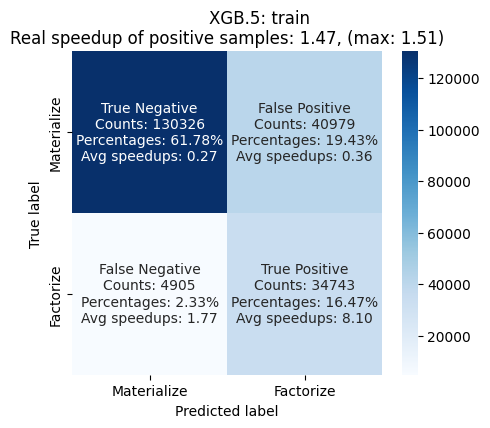

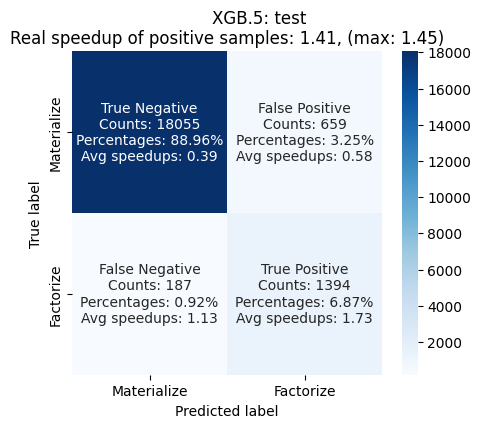

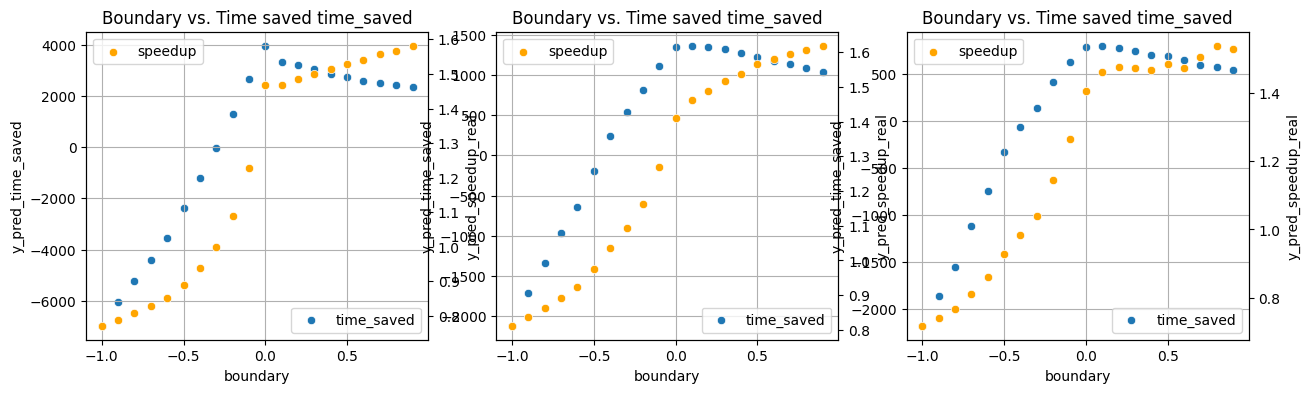

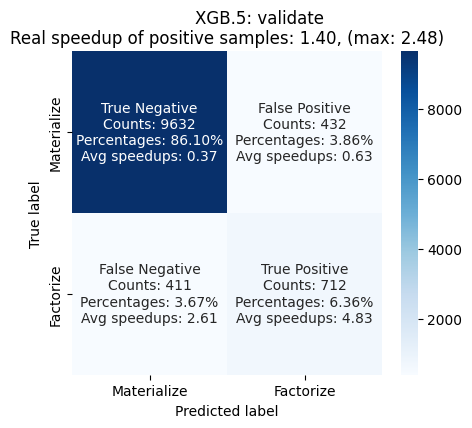

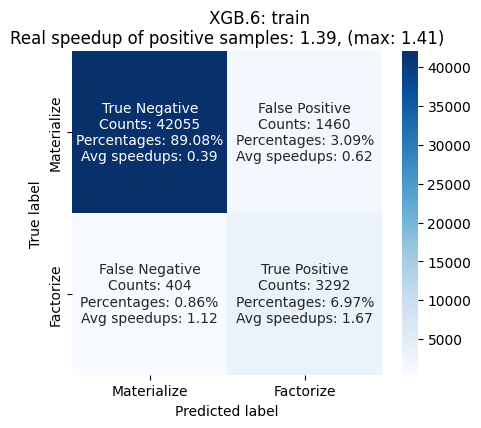

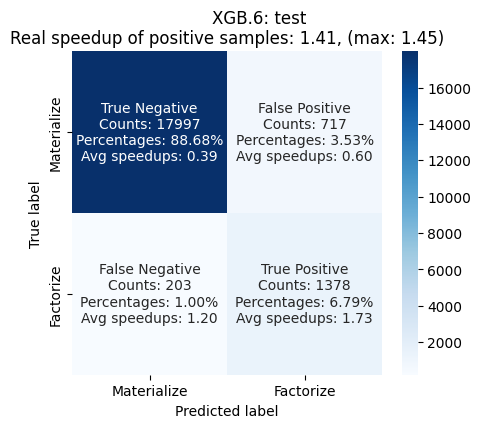

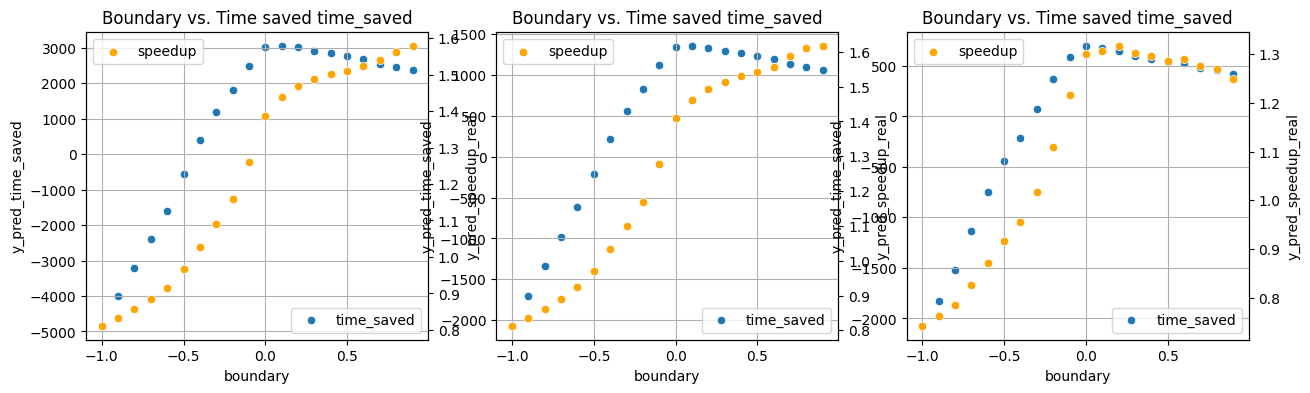

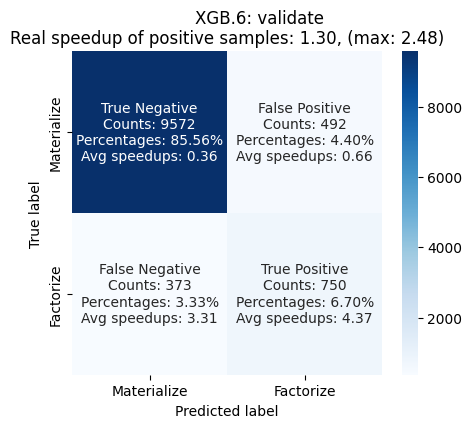

In [9]:
l= list(zip(["speedup", "time_saved", ["times_mean", "materialized_times_mean"]]*2, [True, False]*3))
l.sort(key=lambda x: str(x[0]))
display(l)
xgb_results = {}
xgb_estimators = {}
for i, (target_col, only_model) in enumerate(l):
    xgb_estimators[f"XGB.{i+1}"] = (target_col, only_model), train_and_eval(f"XGB.{i+1}",X_train, y_train, X_test, y_test, X_validate, y_validate, target_col, only_model=only_model)


In [10]:
# import pickle
# with open("trained_models/xgb3.pkl", "wb") as f:
#     pickle.dump(xgb_estimators["XGB.3"][1], f)

In [11]:
xgb_results

{('XGB.1', 'train'): {'r2': 0.9856458890671467,
  'mean_squared_error': 0.17008074199816697,
  'accuracy': 0.9653046959395056,
  'precision': 0.7413227016885553,
  'recall': 0.8552489177489178,
  'f1': 0.7942211055276381,
  'speedup': {'y_true_mat_time': 10928.625975152081,
   'y_true_fact_time': 7723.45381848659,
   'y_true_best_time': 7723.45381848659,
   'y_true_time_saved': 3205.1721566654915,
   'y_true_speedup_avg': 1.6089203654908626,
   'y_true_speedup_real': 1.41499207893154,
   'y_pred_mat_time': 10724.939477234862,
   'y_pred_fact_time': 7677.544544201699,
   'y_pred_best_time': 7580.043382436759,
   'y_pred_time_saved': 3047.3949330331634,
   'y_pred_speedup_avg': 1.411002324640522,
   'y_pred_speedup_real': 1.3969231198189065,
   'TP': (3161, 1.68896621318083, 3144.8960947981022),
   'FP': (1103, 0.6144077175000741, -97.5011617649401),
   'TN': (42412, 0.38990148636951916, -74576.43207505383),
   'FN': (535, 1.1359765812890172, 60.2760618673903)}},
 ('XGB.1', 'test'): {'r2

In [12]:
resdf = pd.DataFrame(xgb_results.values())
resdf['Model'] = [x[0] for x in xgb_results.keys()]
resdf['dataset'] = [x[1] for x in xgb_results.keys()]
resdf['target'] = np.array([[str(x[0])] * 3 for x in l]).flatten()
resdf['target'] = resdf['target'].replace({"['times_mean', 'materialized_times_mean']": "time_saved"})
resdf['pruned'] = np.array([[x[1]] * 3 for x in l]).flatten()
resdf = resdf.merge(pd.json_normalize(resdf.speedup), left_index=True, right_index=True)
resdf['fraction_of_optimal_time_saved'] = resdf.y_pred_time_saved / resdf.y_true_time_saved
resdf

,r2,mean_squared_error,accuracy,precision,recall,f1,speedup,Model,dataset,target,...,y_pred_fact_time,y_pred_best_time,y_pred_time_saved,y_pred_speedup_avg,y_pred_speedup_real,TP,FP,TN,FN,fraction_of_optimal_time_saved
0,0.985646,0.170081,0.965305,0.741323,0.855249,0.794221,"{'y_true_mat_time': 10928.625975152081, 'y_tru...",XGB.1,train,time_saved,...,7677.544544,7580.043382,3047.394933,1.411002,1.396923,"(3161, 1.68896621318083, 3144.8960947981022)","(1103, 0.6144077175000741, -97.5011617649401)","(42412, 0.38990148636951916, -74576.43207505383)","(535, 1.1359765812890172, 60.2760618673903)",0.950774
1,0.960431,0.496353,0.963932,0.732858,0.845035,0.784959,"{'y_true_mat_time': 4675.457687211972, 'y_true...",XGB.1,test,time_saved,...,3194.183916,3137.129292,1358.658575,1.442891,1.425354,"(1336, 1.7518031840517563, 1415.713199364909)","(487, 0.5954432733688023, -57.05462402687171)","(18227, 0.3919107701991316, -32531.602519038664)","(245, 1.1598251278586296, 37.14936060620651)",0.935160
2,0.615732,7.730321,0.930008,0.657699,0.631345,0.644253,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.1,validate,time_saved,...,1978.357305,1727.006394,756.727263,3.045078,1.382503,"(709, 4.3242315695542, 1008.0781731741256)","(369, 0.587300351108708, -251.35091057812886)","(9695, 0.3685736958717938, -15206.433133838713)","(414, 3.490526327580848, 659.3699089258384)",0.453824
3,0.986317,0.041710,0.710950,0.367465,0.745737,0.492332,"{'y_true_mat_time': 12626.240700269875, 'y_tru...",XGB.2,train,time_saved,...,8578.466833,8369.713176,3961.343309,3.429559,1.461778,"(29567, 8.8198163170156, 4170.096966115636)","(50895, 0.2981369264943995, -208.75365694013507)","(120410, 0.29158327834345615, -77585.00749905614)","(10081, 2.8931104022600205, 103.32143375973492)",0.926973
4,0.959005,0.514248,0.956787,0.679044,0.844402,0.752749,"{'y_true_mat_time': 4675.457687211972, 'y_true...",XGB.2,test,time_saved,...,3263.760788,3196.130181,1341.868879,1.374324,1.411142,"(1335, 1.7430646671083982, 1409.499486221656)","(631, 0.5941827697908614, -67.63060685539031)","(18083, 0.39033396863419484, -32521.02653621015)","(246, 1.2096539822308883, 43.363073749459744)",0.923603
5,0.563158,8.787951,0.902297,0.512235,0.559216,0.534696,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.2,validate,time_saved,...,2750.762206,2363.344846,456.721374,2.415303,1.166034,"(628, 4.140713980509141, 844.1387341663237)","(598, 0.6033332508675308, -387.41735997333114)","(9466, 0.3622694408427394, -15070.36668444351)","(495, 3.8597771771164826, 823.3093479336403)",0.273904
6,0.971194,0.005803,0.987164,0.929405,0.904762,0.916918,"{'y_true_mat_time': 10928.625975152081, 'y_tru...",XGB.3,train,speedup,...,7638.239018,7597.084781,3120.595674,1.612786,1.408549,"(3344, 1.6651688267583018, 3161.749909990453)","(254, 0.9231486430521708, -41.15423639067506)","(43261, 0.39249471341326775, -74632.7790004281)","(352, 1.0745599834501904, 43.42224667503926)",0.973612
7,0.903139,0.021586,0.984922,0.914769,0.889311,0.901860,"{'y_true_mat_time': 4675.457687211972, 'y_true...",XGB.3,test,speedup,...,3165.414781,3133.349891,1389.147718,1.658092,1.438852,"(1406, 1.7295281108548188, 1421.2126078561591)","(131, 0.8913765156170168, -32.064889907077976)","(18583, 0.3937237345425577, -32556.59225315846)","(175, 1.1019982077521988, 31.649952114956786)",0.956145
8,0.279919,2.384392,0.954322,0.768421,0.780053,0.774194,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.3,validate,speedup,...,3553.750075,2653.670982,601.242064,3.589508,1.169185,"(876, 4.436747129833779, 1501.321157557162)","(264, 0.77821366769451, -900.0790933470531)","(9800, 0.36577422477191873, -14557.704951069789)","(247, 2.5278040352146096, 166.12692454280204)",0.360576
9,0.986924,3.721971,0.944225,0.830277,0.883929,0.856263,"{'y_true_mat_time': 12626.240700269875, 'y_tru...",XGB.4,train,speedup,...,9337.685985,8932.613920,3610.754151,6.857081,1.386686,"(35046, 8.107992060728824, 4015.826216361033)","(7164, 0.7376721439181653, -40

/tmp/ipykernel_27131/2002249022.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_27131/2002249022.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_27131/2002249022.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_27131/2002249022.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


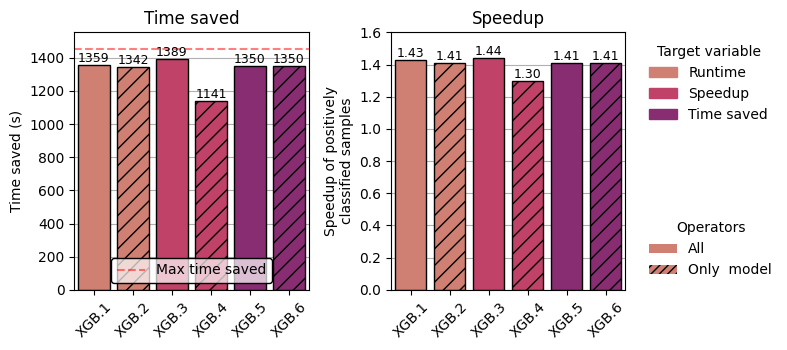

In [13]:
import matplotlib

pal = sns.color_palette("flare", 3)
colors = [pal[0], pal[0], pal[1], pal[1], pal[2], pal[2]]
colors = [sns.set_hls_values(c, s=0.5) for c in colors]
hatches = ["", "//", "", "//", "", "//"]	

f, axs = plt.subplots(1, 2, figsize=(8, 0.45*8))
labels = ["Time saved (s)", "Speedup of positively\nclassified samples", "Fraction of best time saved"]
titles = ["Time saved", "Speedup", "Performance"]
max_time_saved = resdf[resdf.dataset=='test'].y_true_time_saved.max()

for ax, var, label, title in zip(axs, ["y_pred_time_saved", "y_pred_speedup_real", "fraction_of_optimal_time_saved"][:2], labels[:2], titles[:2]):
    sns.barplot(
        data=resdf[(resdf.dataset == "test")],
        x="Model",
        y=var,
        ax=ax,
        saturation=0.6,
        edgecolor="black",
        linewidth=1,
        palette=sns.color_palette("flare"),
        # hue="target",
        # style='target'
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    ax.set_ylabel(label)
    ax.set_xlabel("Target variable")
    ax.set_xlabel(None)
    ax.set_title(title)
    # ax.set_xticklabels(["XGB.1\nSpeedup", "XGB.2\nTime saved", "XGB.3 Time saved\n(separate F/M)"], rotation=45)
    fmt = ".2f"
    if var == "fraction_of_optimal_time_saved":
        # ax.set_ylim(0, 1)
        ...
    elif var == "y_pred_speedup_real":
        ax.set_ylim(top=1.6)
        ...
    elif var == "y_pred_time_saved":
        # ax.set_ylim(0, 1400)
        # ax.set_ylim(1000, max_time_saved+100)
        fmt = ".0f"
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max time saved", alpha=0.5)
        legend = ax.legend(loc='lower center', framealpha=0.8, fancybox=True)
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_facecolor((1, 1, 1, 0.7))
        ax.set_ylim(top=max_time_saved+100)
        
    for i, bar in enumerate(ax.patches):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), format(bar.get_height(), fmt), 
                ha='center', va='bottom', fontsize=9)
        bar.set_facecolor(colors[i])
        bar.set_hatch(hatches[i])

cs = {'Runtime':colors[0], 'Speedup':colors[2], 'Time saved':colors[4]}         
labels = list(cs.keys())
handles = [plt.Rectangle((0,0),1,1, color=cs[label]) for label in labels]  
l1 = axs[1].legend(handles, labels, loc='upper left', title="Target variable", bbox_to_anchor=(1.05, 1), frameon=False)
hatches = {'All': None, 'Only  model': r'////'}
handles = [matplotlib.patches.Patch(facecolor=colors[0], hatch=hatches[label]) for label in hatches.keys()]
l2 = axs[1].legend(handles, hatches.keys(), loc='lower left', title="Operators" , bbox_to_anchor=(1.05, 0), frameon=False)
axs[1].add_artist(l1)
# axs[1].add_artist(l2)
f.tight_layout()
# f.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/xgb-models-compare.pdf", bbox_inches='tight')

In [14]:
y_true = y_validate.speedup
for m, target in zip(["XGB.3", "XGB.5"], ["speedup", "time_saved"]):
    y_pred = xgb_estimators[m][1].predict(X_validate)
    boundary = 1.0 if target == "speedup" else 0.0
    # pd.DataFrame({f"xgb_y_true_{target}": y_true > boundary, f"xgb_y_pred_{target}": y_pred >boundary}).to_csv(
    #     f"evaluation/predictions/{m.replace('.','')}_label.csv"
    # )

In [15]:
X_validate

,operator,num_cores,selectivity,cardinality_T,cardinality_S,join,complexity_ratio,compute_type,parallelism,mem_mat_read,...,morpheusfi_eis_0,morpheusfi_eis_1,morpheusfi_eis_2,morpheusfi_eis_missing_0,morpheusfi_eis_missing_1,morpheusfi_nis_0,morpheusfi_nis_1,morpheusfi_nis_2,morpheusfi_nis_missing_0,morpheusfi_nis_missing_1
158716,Linear Regression,-1,1.053850,100000,105385,left,1.632133,gpu,NaN,2.555120e+09,...,0.000000,NaN,NaN,NaN,NaN,5385.0,NaN,NaN,NaN,NaN
158717,Gaussian,-1,1.053850,100000,105385,left,1.632133,gpu,NaN,1.635777e+09,...,0.000000,NaN,NaN,NaN,NaN,5385.0,NaN,NaN,NaN,NaN
158718,KMeans,-1,1.053850,100000,105385,left,1.830240,gpu,NaN,4.428798e+09,...,0.000000,NaN,NaN,NaN,NaN,5385.0,NaN,NaN,NaN,NaN
158719,Logistic Regression,-1,1.053850,100000,105385,left,1.632133,gpu,NaN,2.555120e+09,...,0.000000,NaN,NaN,NaN,NaN,5385.0,NaN,NaN,NaN,NaN
158734,Linear Regression,-1,1.005260,100000,100526,inner,1.728065,gpu,NaN,2.555120e+09,...,0.000000,NaN,NaN,NaN,NaN,526.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347740,Linear Regression,-1,0.914657,7634583,6983028,inner,1.328242,gpu,NaN,8.434221e+11,...,0.002081,NaN,NaN,NaN,NaN,6976320.0,NaN,NaN,NaN,NaN
347741,Gaussian,-1,0.914657,7634583,6983028,inner,1.328242,gpu,NaN,7.552067e+11,...,0.002081,NaN,NaN,NaN,NaN,6976320.0,NaN,NaN,NaN,NaN
347742,Logistic Regression,-1,0.914657,7634583,6983028,inner,1.328242,gpu,NaN,8.434221e+11,...,0.002081,NaN,NaN,NaN,NaN,6976320.0,NaN,NaN,NaN,NaN
347743,Linear Regression,-1,0.906157,8123214,7360911,inner,1.336526,gpu,NaN,9.256315e+11,...,0.002092,NaN,NaN,NaN,NaN,7353840.0,NaN,NaN,NaN,NaN


In [16]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer


# def time_saved(y_true, y_pred):
#     tot_time_pred = y_true[y_pred > 0].sum()
#     return tot_time_pred
       

# # Define the hyperparameter grid
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7, 1], 
#     "lambda": [0.5, 1, 2],
#     "alpha": [0.5, 1, 2],
# }

# # Create the XGBoost model object
# xgb_model = xgboost.XGBRegressor(enable_categorical=True)

# # Create the GridSearchCV object
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring={"time_saved": make_scorer(time_saved, greater_is_better=True),
#                                                                  "mse": "neg_mean_squared_error"}, refit="time_saved", verbose=3)

# target_col = 'time_saved'
# loc = X_train["operator"].isin(model_operators)
# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train.loc[loc], y_train.loc[loc][target_col])

# # Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [17]:
# train_and_eval(X_train, y_train, X_test, y_test, X_validate, y_validate, 'time_saved', only_model=True, estimator_kwargs={'alpha': 0.5, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7})

In [18]:
# train_and_eval(X_train, y_train, X_test, y_test, X_validate, y_validate, ['materialized_times_mean', 'times_mean'], only_model=True, estimator_kwargs={'alpha': 2, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7})

In [107]:
sns.color_palette("flare", 2)

[(0.87199254, 0.3633634, 0.35974223), (0.60407977, 0.21017746, 0.43913439)]

In [72]:
feature_names = {
    'operator': 'Model type',
    'r_S_1': 'Rows in S, $r_{S_1}$',
    'nnz_S_sum': 'Num. non-zero in S, $\sum_{k=1}^{n}nnz(S_k)$',
    'complexity_ratio': 'Complexity ratio, $\\frac{FLOP_M}{FLOP_F}$',
    'fr': 'Feature ratio, $\\rho$',
    'sparsity_T': 'Sparsity of T, $e_T$',
    'features_4': 'Scalar operator complexity',
    'mem_fac_read': 'Bytes read ($F$)',
    'cardinality_T': 'Rows in T, $r_T$',
    'comp_mat': 'Complexity ($M$) $M_{FLOP}$',
    'features_3': 'Bytes written ($F$)',
    'mem_mat_read': 'Bytes read ($M$)',
    'nnz_S_0': 'Num. non-zero in S_0, $nnz(S_0)$',
}

/tmp/ipykernel_27131/4262796665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(feat_importances, x="gain", y="features", palette=colors, edgecolor='black',ax=ax)
/tmp/ipykernel_27131/4262796665.py:17: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(feat_importances, x="gain", y="features", palette=colors, edgecolor='black',ax=ax)
/tmp/ipykernel_27131/4262796665.py:17: UserWarning: The palette list has more values (13) than needed (10), which may not be intended.
  sns.barplot(feat_importances, x="gain", y="features", palette=colors, edgecolor='black',ax=ax)
/tmp/ipykernel_27131/4262796665.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


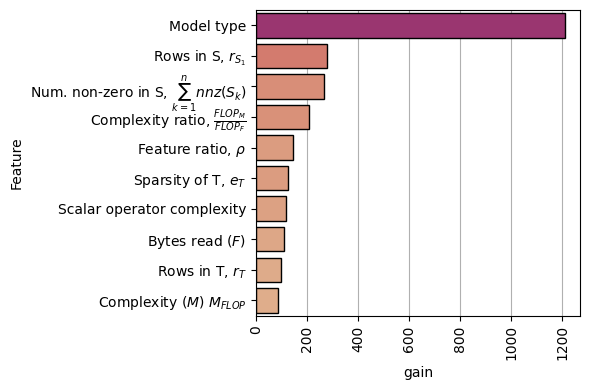

In [120]:
import seaborn as sns
gain = xgb_estimators['XGB.5'][1].get_booster().get_score(importance_type="gain")
feat_importances = pd.DataFrame.from_dict({"features": gain.keys(), "gain": gain.values()}).sort_values("gain", ascending=False)[:13]

feat_importances['features'] = feat_importances['features'].map(pd.Series(feature_names))
import matplotlib.pyplot as plt
# Create a colormap
cmap = plt.get_cmap("flare")

# Normalize the gain values to range [0, 1] for color mapping
norm = plt.Normalize(feat_importances['gain'].min(), feat_importances['gain'].max())

# Map the normalized gain values to colors
colors = cmap(norm(feat_importances['gain']))

fig,ax = plt.subplots(figsize=(0.75*8, 4))
sns.barplot(feat_importances, x="gain", y="features", palette=colors, edgecolor='black',ax=ax)
ax.patches[0].set_facecolor(sns.color_palette("flare", 2)[1])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(axis="x")
ax.set_ylabel("Feature")
ax.set_axisbelow(True)

fig.tight_layout()
fig.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/xgboost-feat-importance.pdf", bbox_inches='tight')